# Introduction

In today's world, smartphones and apps like Spotify have made it easy to listen to music anywhere and all the time. Personally, listening to music helps me focus and calms me when I am stressed. However, recently, I got bored of listening to the same songs everytime and wanted to explore new songs. That's when it hit me that, using the knowledge that I have gained, it would be amazing to analyze the type of music that I listen to and use that to predict a few songs that I'd enjoy.

This tutorial aims to demonstrate the application of the Data Science pipeline on the topic of Music Analysis and Song Recommendation. We'll first use the Spotify API to scrape songs from Spotify and obtain audio features. We will then visualize these features to get a sense of what kind of songs I listen to. Next, we will perform Principal Component Analysis to reduce dimensionality of our features. Lastly, we will use Logistic Regression to train our model and predict the results on a set of test data points - effectively recommending new music!

# Setting up

Run the following to ensure that all the libraries necessary are installed.

In [105]:
# These libraries should be available when you installed Anaconda for the class.
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Collection

I will use the Spotify Web API to collect songs as I have saved a library of 255 songs on Spotify. There are two ways with which Spotify data can be accessed:

1. **Spotipy Library**: [Spotipy](http://spotipy.readthedocs.io/en/latest/) is a Python library that makes it easy to use the Spotify Web API.

2. **Spotify Web Console**: The Spotify Web Console allows developers to make simple requests, and displays the corresponding CURL request. You can either run a simple query on the website and copy paste the results or you can run the CURL command in terminal and output the results to a file.

Following is a screenshot of what the Spotify Web Console looks like:

[<img src="https://github.com/vr96/PDSTutorial15388/blob/master/Images/spotifyWebConsole.png?raw=true">](https://github.com/vr96/PDSTutorial15388/blob/master/Images/spotifyWebConsole.png?raw=true)

For this tutorial, I used both methods as necessary and saved the data in .txt files. While, I'll show snippets or link you to a tutorial for both methods, the bulk of the processing will occur by reading from the .txt files, for ease of use. I'll provide downloadable links to these .txt files.

## Scraping songs from Spotify

For our training set, I decided to classify songs into positive and negative songs. The positive songs are the ones that I have saved in my Spotify library. The negative ones are songs that I have listened to before but did not save to my library.

To collect the positive songs, I first setup my Spotify developer account, registered my app and obtained my API keys by following Spotify's getting started tutorial: https://developer.spotify.com/web-api/tutorial/. 

Then, I used this demo: https://github.com/perelin/spotipy_oauth_demo/blob/master/spotipy_oauth_demo.py to setup a quick server to authenticate myself. Next, I used the `current_user_saved_tracks` method from Spotipy's reference guide at: http://spotipy.readthedocs.io/en/latest/, to access my account and retrieve all the songs from my library. 

I saved these results in `positiveSongs.txt` which can be downloaded here: 
https://github.com/vr96/PDSTutorial15388/raw/master/positiveSongs.txt


Spotify doesn't have a simple way to find the negative songs. Instead, I found the playlists that I have listened to. The songs that weren't saved were classified as negative songs. I followed the method above and saved all the negative songs in `negativeSongs.txt`, which can be downloaded here: https://github.com/vr96/PDSTutorial15388/raw/master/negativeSongs.txt. There's a total of 236 negative songs. 

Save these files in the same directory as this ipynb notebook.

# Data Processing

We are now ready to access the information from the .txt files. I have created a couple of helper functions below to aid this process:

In [70]:
'''
Reads the contents from a file and converts single quotes to double quotes.

Input: 
fileName - name of file to be read (String)
singleQuotesCheck - flag to convert single quotes to double quotes (Boolean)

Output:
contents - Json contents of the file

'''
def readFromFile(filename, singleQuotesCheck):
    f = open(filename, "r") 
    contents = f.read()
    if singleQuotesCheck:
        contents = contents.replace("'", '"')
    contents = json.loads(contents)

    return contents

In [108]:
'''
Gets the name, artist and ID of each song. We will use the IDs to receive the audio features in a moment.

Input: 
items - Json object containing the contents of a file. (List of dictionaries)

Output:
names - Names of all songs. (List)
ids - IDs of all songs. (List)
artists - Artist names of all songs. (List)

'''
def getInfo(items):
    names = []
    ids = []
    artists = []

    for i in range(len(items)):
        item = items[i]
        
        # Based on whether I queried a playlist or a list of individual track,
        # some data points have info about the song in the "track" key. For these
        # songs, I am indexing into the track itself.
        if 'track' in item.keys():
            item = item['track']

        names.append(item['name'])
        ids.append(item['id'])
        artist = item['artists'][0]['name']
        artists.append(artist)

    return (names, ids, artists)

Great! Now that we have defined our helper functions, we are ready to start using real data! 

We will first read the dataset of the positive songs. 

In [109]:
# Positive Dataset
posSongs = readFromFile("positiveSongs.txt", False)
posSongs = posSongs['items']

Now, let's get the names, ids and artists of the postive songs.

In [110]:
(posNames, posIds, posArtists) = getInfo(posSongs)
print(posNames)

['One More Night - 2016 Remastered', 'Do You Remember? - 2016 Remastered', 'Do You Remember Rock And Roll Radio', 'All Of My Life - 2016 Remastered', 'More Than a Feeling', 'Walking On Sunshine - Original Version', 'Walking On Sunshine', 'One Step Closer', 'Seven Nation Army', 'On Top Of The World', 'Rock and Roll Part 2 (Hey Song) - TV Sports Mix', 'Good Grief', 'The Deepest Blues Are Black', 'This Is a Call', 'Take Five', 'In the Mood', 'Follow Me', 'Bad, Bad Leroy Brown', "Dr. No's Fantasy (Remastered)", "It's Oh, So Nice", "It's Sand, Man! - 78rpm Version", 'At Last - Single Version', "That's Life", 'You Make Me Feel So Young - 1998 Digital Remaster', 'Let It Snow! Let It Snow! Let It Snow!', 'Two Princes', 'Teach Me Tonight', 'Fly Me To The Moon', 'The Way You Look Tonight', 'Hello, Dolly!', 'The Girl From Ipanema - 1992 Digital Remaster', 'I Got You (I Feel Good)', 'What A Wonderful World - Single Version', 'The Imperial March - From "Star Wars: The Empire Strikes Back"', 'The Pi

We will now repeat the process for the negative songs.

In [111]:
negSongs = readFromFile("negativeSongs.txt", False)
negSongs = negSongs['items']
(negNames, negIds, negArtists) = getInfo(negSongs)
print(negNames)

['Despacito - Remix', "I'm the One", 'Shape of You', 'HUMBLE.', 'Mask Off', 'Something Just Like This', 'Stay (with Alessia Cara)', "It Ain't Me (with Selena Gomez)", 'Swalla (feat. Nicki Minaj & Ty Dolla $ign)', 'Malibu', "There's Nothing Holdin' Me Back", "That's What I Like", 'Symphony (feat. Zara Larsson)', 'Despacito (Featuring Daddy Yankee)', 'Attention', 'Passionfruit', 'Sign of the Times', 'XO TOUR Llif3', 'First Time', 'Felices los 4', 'Unforgettable', 'DNA.', 'Issues', 'Scared to Be Lonely', 'Galway Girl', 'Slide', 'Congratulations', 'No Promises (feat. Demi Lovato)', '1-800-273-8255', 'Thunder', 'SUBEME LA RADIO', 'Pretty Girl - Cheat Codes X CADE Remix', 'Me Rehúso', 'The Cure', 'iSpy (feat. Lil Yachty)', 'Good Life (with G-Eazy & Kehlani)', 'Now Or Never', 'Believer', 'Location', 'Rockabye (feat. Sean Paul & Anne-Marie)', 'Paris', 'Call On Me - Ryan Riback Extended Remix', 'Rollin', 'I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Mot



The above concludes the extraction of the training set. Now, to extract the test set, I picked songs from multiple playlists across genres and added them to a separate test playlist. I haven't listened to any of the songs in this playlist, yet. The playlist can be found here: https://open.spotify.com/user/gundadhur/playlist/6iRm5ApLYmmbK28YVJXhro

I used the following request to get access to all the information in the playlist:

`curl -X GET "https://api.spotify.com/v1/users/gundadhur/playlists/6iRm5ApLYmmbK28YVJXhro/tracks" -H "Authorization: Bearer {Enter your Authorization Token Here} > testSetSongs.txt`

The songs were saved in testSetSongs.txt, which can be downloaded here: https://github.com/vr96/PDSTutorial15388/raw/master/testSetSongs.txt

We can read the contents of the file and get the name, artist and id information the same way as we did for the training data.

In [100]:
testContents = readFromFile("testSetSongs.txt", False)
testItems = testContents['items']
(testNames, testIds, testArtists) = getInfo(testItems)
print(testNames)

['Paint It, Black - Mono / Remastered', 'Hallowed Be Thy Name - 1998 Remastered Version', 'Gimme Shelter', 'Born To Be Wild', 'Lost', 'Rock You Like A Hurricane', 'Pour Some Sugar On Me - Remastered 2017', 'Crazy Train - Remastered', 'Jump', "Runnin' With The Devil - 2015 Remastered Version", 'All the Things You Are', 'Another One Bites The Dust', 'Money', 'Kashmir', "Free Fallin'"]


# Feature Extraction

We can now get all the audio features from our dataset. We will explore and use these features for our model. We have access to `Acousticness`, `Danceability`, `Duration`, `Energy`, `Instrumentalness`, `Liveness`, `Loudness`, `Speechiness`, `Tempo` and `Valence`. The description of each feature can be found here: https://developer.spotify.com/web-api/get-audio-features/

A snippet of this extraction using Spotipy is below. It can't be run as I didn't include the API keys in this notebook (for obvious reasons).

In [77]:
'''
Gets the audio features for all songs.

Inputs: 
ids - List of ids of all songs. (List)

Outputs:
finFeatures - List of dictionaries of features of each songs. (List of dictionaries)

'''

def getAudioFeatures(ids):
    
    # Initialize credentials manager using the client credentials.
    client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
    
    # Create a spotipy object using the manager.
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    itemsLength = len(ids)
    
    # Using a limit to abide by rate limiting rules.
    currCount = 0
    limitCount = 99

    finFeatures = []
    while currCount < itemsLength:
        # Get features from the list of songs.
        features = sp.audio_features(ids[currCount:currCount+limitCount])

        finFeatures += features
        currCount += limitCount
    
    # Return the list of features.
    return finFeatures


The results of the above function were stored in the following files:

1. positiveSongsFeatures.txt: Features of positive songs. Download link:  https://github.com/vr96/PDSTutorial15388/raw/master/positiveSongsFeatures.txt
2. negativeSongsFeatures.txt: Features of negative songs. Download link:  https://github.com/vr96/PDSTutorial15388/raw/master/negativeSongsFeature.txt
3. testSetFeatures.txt: Features of test songs. Download link: https://github.com/vr96/PDSTutorial15388/raw/master/testSetFeatures.txt

Now, we will read the features from the appropriate features file.

In [112]:
# Read the features of the positive songs.
posFeatures = readFromFile("positiveSongsFeatures.txt", True)
posFeatures = posFeatures["features"]

# Read the features of the negative songs.
negativeFeatures = readFromFile("negativeSongsFeature.txt", True)
negativeFeatures = negativeFeatures["features"]

# Read the features of the test songs.
testFeatures = readFromFile("testSetFeatures.txt", True)
testFeatures = testFeatures["features"]

### Storing the data in Data Frames

Now, that we have finally collected all our data and extracted the features, we can store all the information in dataframes.

First, let's create the dataframe of positive features.

In [102]:
# Creates a dataframe from the positive features.
posFeaturesDf = pd.DataFrame(posFeatures)
# Given a lot of extraneous features, we are just picking the 8 that can be most easily compared.
posFeaturesDf = posFeaturesDf[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
# Add the name of the songs as a column.
posFeaturesDf.insert(loc=0, column='name', value=posNames)
# Add the artist information as a column.
posFeaturesDf.insert(loc=1, column='artists', value=posArtists)
# Positive songs are labelled with a '1'.
posFeaturesDf['savedTrack'] = 1

Next, let's create the dataframe of negative features.

In [103]:
# Creates a dataframe from the negative features.
negFeaturesDf = pd.DataFrame(negativeFeatures)
# Pick the 8 features that can be most easily compared.
negFeaturesDf = negFeaturesDf[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
# Add the name of the songs as a column.
negFeaturesDf.insert(loc=0, column='name', value=negNames)
# Add the artist information as a column.
negFeaturesDf.insert(loc=1, column='artists', value=negArtists)
# Negative songs are labelled with a '0'.
negFeaturesDf['savedTrack'] = 0

We will now combine the positive and negative dataframes, to create a dataframe for the overall training set, containing a total of 491 songs.

In [81]:
finalFeaturesDf = posFeaturesDf.append(negFeaturesDf, ignore_index=True)
finalFeaturesDf.head(10)

,name,artists,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,savedTrack
0,One More Night - 2016 Remastered,Phil Collins,0.788000,0.534,0.442,0.000351,-9.442,0.0308,136.369,0.343,1
1,Do You Remember? - 2016 Remastered,Phil Collins,0.117000,0.677,0.500,0.010900,-7.839,0.0248,93.051,0.525,1
2,Do You Remember Rock And Roll Radio,Ramones,0.445000,0.302,0.961,0.002680,-5.619,0.1160,152.366,0.659,1
3,All Of My Life - 2016 Remastered,Phil Collins,0.064700,0.544,0.388,0.000303,-8.596,0.0377,169.952,0.240,1
4,More Than a Feeling,Boston,0.000894,0.377,0.682,0.002170,-8.039,0.0299,108.736,0.288,1
5,Walking On Sunshine - Original Version,Aly & AJ,0.017200,0.650,0.961,0.000000,-3.149,0.0390,108.982,0.935,1
6,Walking On Sunshine,Katrina & The Waves,0.011600,0.596,0.869,0.173000,-11.970,0.0370,109.902,0.944,1
7,One Step Closer,Linkin Park,0.001400,0.492,0.969,0.000001,-4.419,0.0491,95.136,0.538,1
8,Seven Nation Army,The White Stripes,0.008170,0.737,0.463,0.447000,-7.828,0.0792,123.881,0.324,1
9,On Top Of The World,Imagine Dragons,0.089400,0.640,0.924,0.000004,-5.577,0.1850,99.959,0.776,1


Lastly, we can do the same for the test features as well. 

In [82]:
# Creates a dataframe from the test features.
testFeaturesDf = pd.DataFrame(testFeatures)
# Pick the 8 features that can be most easily compared.
testFeaturesDf = testFeaturesDf[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
# Add the name of the songs as a column.
testFeaturesDf.insert(loc=0, column='name', value=testNames)
# Add the artist information as a column.
testFeaturesDf.insert(loc=1, column='artists', value=testArtists)

testFeaturesDf.head()

,name,artists,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
0,"Paint It, Black - Mono / Remastered",The Rolling Stones,0.010700,0.506,0.838,0.04530,-7.423,0.0918,159.739,0.785
1,Hallowed Be Thy Name - 1998 Remastered Version,Iron Maiden,0.001680,0.307,0.911,0.13600,-5.193,0.0364,104.905,0.343
2,Gimme Shelter,The Rolling Stones,0.463000,0.630,0.616,0.04080,-8.128,0.0309,118.650,0.509
3,Born To Be Wild,Steppenwolf,0.273000,0.439,0.737,0.28000,-12.054,0.1150,145.942,0.533
4,Lost,Avenged Sevenfold,0.000058,0.214,0.955,0.00015,-3.576,0.0687,179.997,0.393


Great! So far, we have collected all the data that we needed, extracted a few features from the songs and saved them into dataframes. Now, we are ready to move on to the next part of the Data Science Pipeline!




# Data Visualization

We are ready to visualize each of the features that we have collected! This will gives us an overall sense of our listening habits broken down into individual features. We can even see how well it correlates with the genres of music that we listen to!

To achieve this, we will first split all the data by the columns as follows:

In [83]:
posAcousticness = posFeaturesDf['acousticness']
posDanceability = posFeaturesDf['danceability']
posEnergy = posFeaturesDf['energy']
posInstrumentalness = posFeaturesDf['instrumentalness']
posLoudness = posFeaturesDf['loudness']
posSpeechiness = posFeaturesDf['speechiness']
posTempo = posFeaturesDf['tempo']
posValence = posFeaturesDf['valence']

Let's visualize the features for just the positive dataset. I have normalized the data so that it is easy to compare between the positive and negative song datasets (as the number of songs in each set differs). We will view the 8 features on a 3 * 3 grid. The code for visualizing the features is as follows:

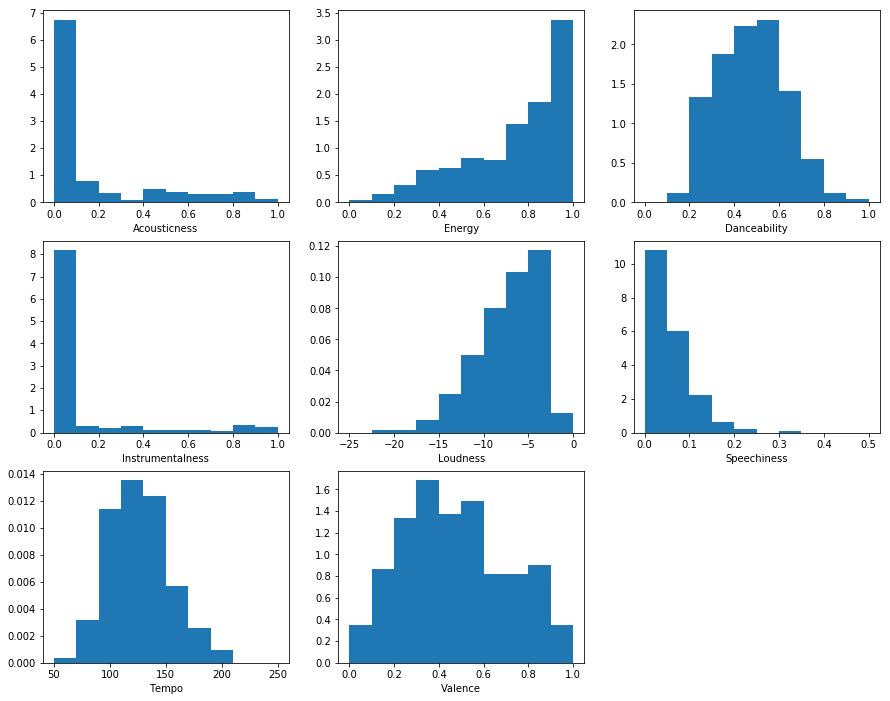

In [84]:
# Set width and height of plot window.
width = 15
height = 12

# Create a figure of given width and height.
fig = plt.figure(figsize=(width, height))

# Add the figure as a subplot of the plot.
ax1 = fig.add_subplot(3, 3, 1)

# Creates a histogram with the acousticsness features, number of bins = 10,
# range of values between 0 and 1, and sets the density to True which 
# results in the normalization of data. The remaining features are set up exactly the same way.
nAcoust, bins, patches = ax1.hist(posAcousticness, 10, range=(0,1), density=True)
ax1.set_xlabel("Acousticness")

ax2 = fig.add_subplot(3, 3, 2)
nEnergy, bins, patches = ax2.hist(posEnergy, 10, range=(0,1), density=True)
ax2.set_xlabel("Energy")

ax3 = fig.add_subplot(3, 3, 3)
nDance, bins, patches = ax3.hist(posDanceability, 10, range=(0,1), density=True)
ax3.set_xlabel("Danceability")

ax4 = fig.add_subplot(3, 3, 4)
nInstru, bins, patches = ax4.hist(posInstrumentalness, 10, range=(0,1), density=True)
ax4.set_xlabel("Instrumentalness")

ax5 = fig.add_subplot(3, 3, 5)
nLoud, bins, patches = ax5.hist(posLoudness, 10, range=(-25,0), density=True)
ax5.set_xlabel("Loudness")

ax6 = fig.add_subplot(3, 3, 6)
nSpeech, bins, patches = ax6.hist(posSpeechiness, 10, range=(0,0.5), density=True)
ax6.set_xlabel("Speechiness")

ax7 = fig.add_subplot(3, 3, 7)
nTempo, bins, patches = ax7.hist(posTempo, 10, range=(50,250), density=True)
ax7.set_xlabel("Tempo")

ax8 = fig.add_subplot(3, 3, 8)
nVal, bins, patches = ax8.hist(posValence, 10, range=(0,1), density=True)
ax8.set_xlabel("Valence")

# Show the results of the plot.
plt.show()

Now, let's visualize the songs in the negative dataset using the same process.

The code for visualizing the normalized negative features is as follows:

In [115]:
negAcousticness = negFeaturesDf['acousticness']
negDanceability = negFeaturesDf['danceability']
negEnergy = negFeaturesDf['energy']
negInstrumentalness = negFeaturesDf['instrumentalness']
negLoudness = negFeaturesDf['loudness']
negSpeechiness = negFeaturesDf['speechiness']
negTempo = negFeaturesDf['tempo']
negValence = negFeaturesDf['valence']

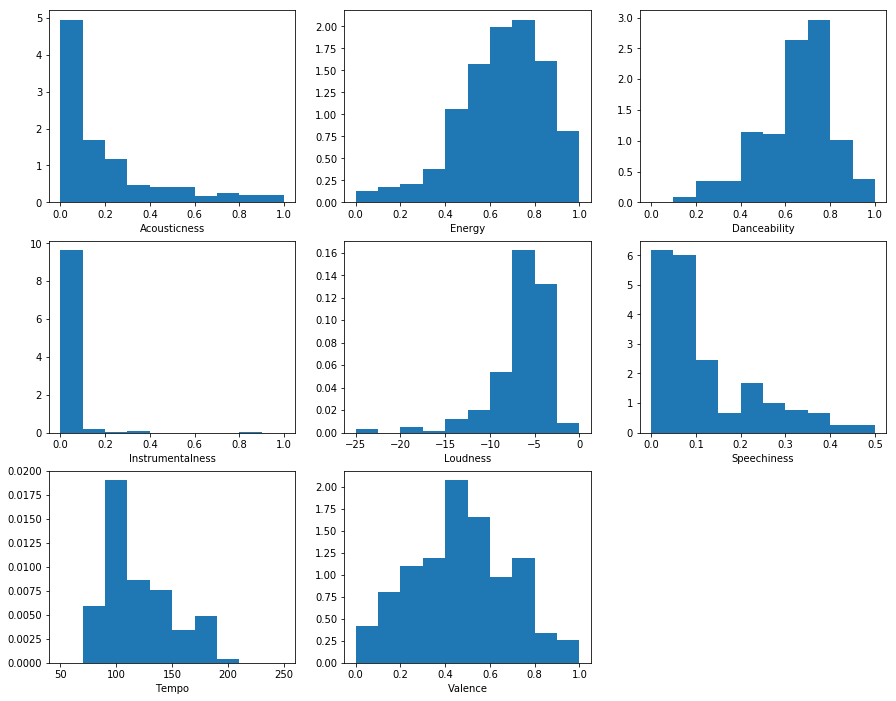

In [116]:
# Set width and height of plot window.
width = 15
height = 12

# Create a figure of given width and height.
fig = plt.figure(figsize=(width, height))

# Add the figure as a subplot of the plot.
ax1 = fig.add_subplot(3, 3, 1)

# Creates a histogram with the acousticsness features, number of bins = 10,
# range of values between 0 and 1, and sets the density to True which 
# results in the normalization of data. The remaining features are set up exactly the same way.
nAcoust, bins, patches = ax1.hist(negAcousticness, 10, range=(0,1), density=True)
ax1.set_xlabel("Acousticness")

ax2 = fig.add_subplot(3, 3, 2)
nEnergy, bins, patches = ax2.hist(negEnergy, 10, range=(0,1), density=True)
ax2.set_xlabel("Energy")

ax3 = fig.add_subplot(3, 3, 3)
nDance, bins, patches = ax3.hist(negDanceability, 10, range=(0,1), density=True)
ax3.set_xlabel("Danceability")

ax4 = fig.add_subplot(3, 3, 4)
nInstru, bins, patches = ax4.hist(negInstrumentalness, 10, range=(0,1), density=True)
ax4.set_xlabel("Instrumentalness")

ax5 = fig.add_subplot(3, 3, 5)
nLoud, bins, patches = ax5.hist(negLoudness, 10, range=(-25,0), density=True)
ax5.set_xlabel("Loudness")

ax6 = fig.add_subplot(3, 3, 6)
nSpeech, bins, patches = ax6.hist(negSpeechiness, 10, range=(0,0.5), density=True)
ax6.set_xlabel("Speechiness")

ax7 = fig.add_subplot(3, 3, 7)
nTempo, bins, patches = ax7.hist(negTempo, 10, range=(50,250), density=True)
ax7.set_xlabel("Tempo")

ax8 = fig.add_subplot(3, 3, 8)
nVal, bins, patches = ax8.hist(negValence, 10, range=(0,1), density=True)
ax8.set_xlabel("Valence")

plt.show()

Awesome, now we are able to visually appreciate the trends in the music that I listen to. We notice the following: 

1. I enjoy more energetic, louder music with high tempo.
2. Most of the songs I like are not instrumental or acoustic. 
3. There is a slight correlation between danceability and valence of the songs. My songs are widely distributed, majority of which are in the middle.
4. The negative set of songs have greater speechiness and danceability but have lower tempo, energy and instrumentalness.

This correlates well with the songs that I prefer. I primarily enjoy Rock songs and listen to a little Jazz. This explains the high energy, loudness and tempo. Neither of these genres involve extremely wordy songs which explains the low speechiness. This is in contrast with the negative songs that span genres including rap (more speechiness), hip-hop (less energy) etc. The rock songs that I dislike provide some resemblance of the positive dataset. 

Now that we have visualized our data and gained some insights from the features of our data, we are ready to use Machine Learning to predict if we like songs in the test dataset!

# Data Modelling and Machine Learning

It's now time for the meat of the tutorial! We will use some machine learning techniques to create a model from our training dataset of songs and then use our model to predict if we will like the songs from the test dataset or not. 

We will first start by extracting our training and testing data. Here, `X` refers to all the features in data (`acousticness`, `loudness` etc). `y` refers to the labels i.e. is the song positive (1) or negative (0).

In [87]:
# We are dropping name and artists, as, for our model, they do not add any value to features. Moreover 'savedTrack'
# is the label, hence, it has to be dropped from the training data.
X_train = finalFeaturesDf.drop(['name', 'artists', 'savedTrack'], axis=1)
y_train = finalFeaturesDf['savedTrack']
# We drop name and artists for the test data set too, for the same reasons as for the training data.
X_test = testFeaturesDf.drop(['name', 'artists'], axis=1)

X_train.head()

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
0,0.788000,0.534,0.442,0.000351,-9.442,0.0308,136.369,0.343
1,0.117000,0.677,0.500,0.010900,-7.839,0.0248,93.051,0.525
2,0.445000,0.302,0.961,0.002680,-5.619,0.1160,152.366,0.659
3,0.064700,0.544,0.388,0.000303,-8.596,0.0377,169.952,0.240
4,0.000894,0.377,0.682,0.002170,-8.039,0.0299,108.736,0.288


### Normalizing data
It is common to normalize our data before we try to fit a model through it. For this, I used the StandardScaler class provided by Scikit-learn, as it automatically normalizes our data to match a gaussian with mean = 0, and standard deviation = 1. 


More information at: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 

In [88]:
# Initialize the StandardScaler class. 
# with_mean centers the data around the mean before scaling the data.
# with_std scales the data to unit variance.
scaler = StandardScaler(with_mean=True, with_std=True)

# We will use this scaler to fit the training data. We should ensure that this is on the training data only.
scaler.fit(X_train)

# Perform standardization by centering and scaling. 
X_train = scaler.transform(X_train)
# Use the same scaler on the test data as well, to maintain consistency.
X_test = scaler.transform(X_test)

X_train

array([[ 2.40758764, -0.14812707, -1.2197199 , ..., -0.70182551,
         0.45390882, -0.58449942],
       [-0.25850021,  0.65419076, -0.94587383, ..., -0.77076086,
        -1.03721354,  0.2265558 ],
       [ 1.04474392, -1.44978958,  1.23073028, ...,  0.27705646,
         1.00456869,  0.82370634],
       ..., 
       [ 0.93349138, -0.13129523,  1.31099551, ..., -0.54786989,
         0.10878687,  2.03583282],
       [ 2.20097577, -0.54648068, -2.05070108, ..., -0.69378305,
        -0.09867872, -0.47309074],
       [ 1.97449736,  0.34560698,  0.38086317, ..., -0.46284963,
        -1.59974924,  1.08663084]])

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a common way to speed up machine learning algorithms. PCA's [wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis) describes that PCA tends to convert possibly correlated variables into a set of linearly uncorrelated variables. PCA is commonly used as it is able to reduce data of high dimensionality to fewer dimensions, making it easier to analyze and train models on.

In our case, we have 8 features, so we are working with 8 dimensional input. The number of features that we want to reduce to depends on the number of features that seem to be correlated. In our case, by eyeballing the visualization charts, we notice that there's a correlation between, acousticness and instrumentalness, energy and loudness and, danceability and valence. Hence, we can reduce these 8 dimensions to 5 uncorrelated dimensions, which was my input to PCA. Later, I tried different number of components to see which model gave me the best output, and, lo and behold, the answer was 5!

Applying PCA is pretty simple using Scikit-learn. There's a PCA class available in their library, that takes in the number of components and allows us to transform our data on the resulting number of dimensions. More information at: 




http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [89]:
# Initialize the PCA class and pass in the number of dimensions to which you want to reduce your data to.
pca = PCA(n_components = 5)

# Fit the training data to the PCA model.
pca.fit(X_train)

# Reduce the dimensionality of the training set.
X_train = pca.transform(X_train)

# Reduce the dimensionality of the testing set.
X_test = pca.transform(X_test)

# Output of the training set
X_train

array([[ 2.40088426, -0.08248985,  0.37401355, -1.13400205, -0.04892167],
       [ 0.60428848, -1.18118369, -0.83260844,  0.09414002, -0.57896374],
       [-0.56931474,  1.07906247,  0.11103445, -1.14960077,  1.03361084],
       ..., 
       [-1.26540238, -0.60429773, -1.04385064, -0.90781057,  1.44752283],
       [ 3.61860755, -0.32632857,  0.2117818 , -1.1704395 , -0.30732753],
       [ 0.67066043, -1.65192651, -0.95543936, -0.04712191,  0.28753746]])

As we can see above, the number of dimensions for each song has reduced to 5. 

### Logistic Regression

Lastly, we want to find the weights for each feature that leads to a specific output. We can then use these same weights on the testset parameters to get a score for the output and classify them as positive or negative songs.

There are many algorithms that can accomplish this task. Two examples include Logistic Regression and Neural Networks. Running a Neural Net might be overkill given our small dataset of only about 500 songs. Hence, I settled on using Logistic Regression.

Logistic Regression is ideal for binary classification. It aims to find the weights of each feature by maximizing the log likelihoods of the features a.k.a [Maximum Likelihood Estimation](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1). This is then written in the form of linear expression of weights and the features. This is known as the logit function. It is essentially the natural log of the ratio of the presence of a feature to the absence of the feature. This is then passed into a sigmoid function, which is defined as:

[<img src="https://github.com/vr96/PDSTutorial15388/blob/master/Images/sigmoidEquation.png?raw=true">](https://github.com/vr96/PDSTutorial15388/blob/master/Images/sigmoidEquation.png?raw=true)

and it looks like:

[<img src="https://github.com/vr96/PDSTutorial15388/blob/master/Images/sigmoidFnGraph.png?raw=true">](https://github.com/vr96/PDSTutorial15388/blob/master/Images/sigmoidFnGraph.png?raw=true)

This has the wonderful property of outputting values between 0 and 1. Lastly, if the output is less than 0.5, the data point is classified as negative and if the output is greater than or equal to 0.5, the data point is classified as positive. The points that are very close to the border can be potentially misclassified. However, this is beyond the scope of this tutorial. More information about logistic regression can be found here:
https://machinelearningmastery.com/logistic-regression-for-machine-learning/

Again, Scikit-learn has a class that helps us perform Logistic Regression, in a few lines of code. Given the training data and the training labels, we can fit a model based on the process described above. More information at: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 

The following code snippet shows how this works:

In [113]:
# Create the logistic regression class. 
# The fit_intercept specifies that a bias term (constant) should be added to the model.
clf = LogisticRegression(fit_intercept=True)

# We can now fit a model through our training data and training labels.
clf = clf.fit(X_train, y_train)

Now, using this model, we can predict the results on the test data! Before I did this prediction, I manually listened to all the songs in the test set and created test labels based on if I liked them or not. Note that I have never listened to these songs before.

In [114]:
# Test labels for the new songs.
y_test = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]

# Predict the labels of the test set using our model.
predicted = clf.predict(X_test)

predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0])

Awesome! We notice that the songs have been more or less accurately predicted to the right label compared to the test labels that I provided. We can now quickly check the accuracy of our model on this small test set using the `score` function on the Linear Regression model. 

In [92]:
# Uses the score function of the Linear Regression model to check the accuracy 
# between the predicted labels and the actual test labels.
val = clf.score(X_test, y_test)
val

0.8666666666666667

Hurray! Our classifier has an accuracy of ~87% (on 15 songs), which means that our model is working quite well! Given a larger collection of songs and playlists, we can predict which songs we would like and which ones we wouldn't, as an actual recommendation system. 

# Final Words and Future Scope

In this tutorial, we went through the entire Data Science pipeline to analyze features of our songs and create a very simple song predictor. 

As with all projects there will always be some scope for improvement. Some ideas that come to mind include:
1. Scraping a lot more songs and using a Neural Net instead of Logistic Regression to achieve, perhaps, an even higher accuracy score on larger test sets. More info on using Scikit-learn for Neural Nets can be found here:
https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html
2. Using lyrics of the songs as a feature. We could do some basic sentiment analyis on the lyrics and see how that corresponds to the valence of the songs and the type of music we listen to. More information about that can be found here: https://opendatascience.com/blog/sentiment-analysis-on-lyrics/
3. We could also use the number of times a song has been listened to by the user over a period of time, to get a greater sense of the specific songs that they enjoy more than the others, which could be a very valuable feature to add to our training dataset.



Thanks a lot for reading along! I hope this tutorial was informational and enjoyable. 